In [1]:
%matplotlib inline

In [2]:
import mne
import pathlib
import numpy as np
from matplotlib import pyplot as plt, ticker

#plt.style.use("minimal.mplstyle")
mne.viz.set_browser_backend("matplotlib")

Using matplotlib as 2D backend.


In [3]:
RAW_DATA_PATH = pathlib.Path("/work/PeterHoueWisnewski#4605/CogNeuro24/EEG/Exam/EEG")

SESSION = "group13_a"

In [4]:
raw = mne.io.read_raw_brainvision(
    vhdr_fname = RAW_DATA_PATH.joinpath(SESSION + ".vhdr"),
    eog = ("HEOG", "VEOG"),
    misc = ("41",),
    preload = True,
    verbose = False
)

raw.load_data()

/tmp/ipykernel_966/453531221.py:1: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(


<RawBrainVision | group13_a.eeg, 33 x 904900 (904.9 s), ~227.9 MB, data loaded>

In [5]:
if SESSION == "group13_c":
    raw.crop(tmin = 1915, tmax = 2300)

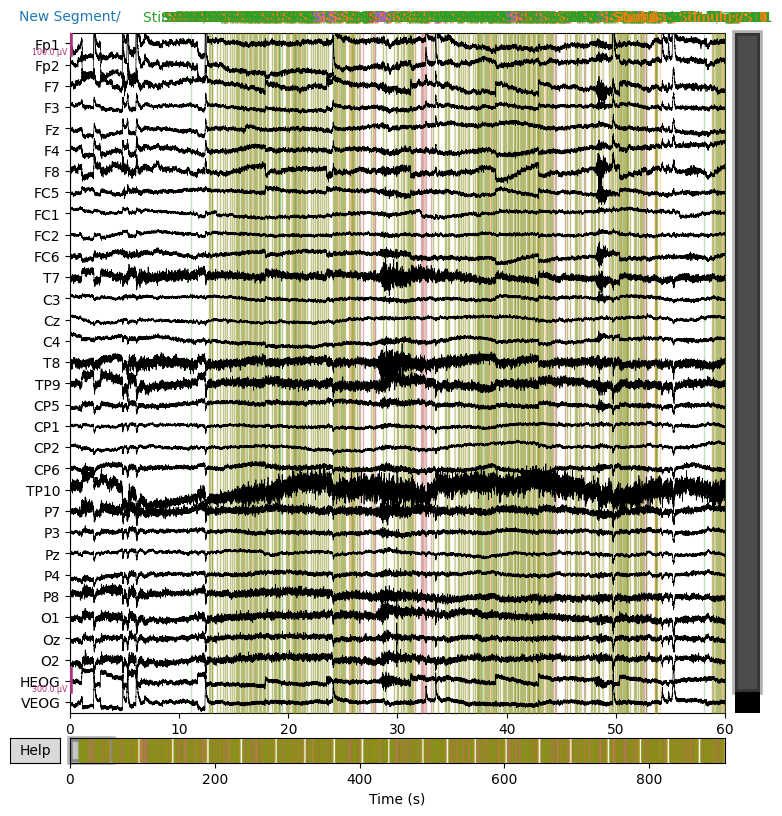

In [6]:
# Specify sensor locations to the 10-20 system
raw.set_montage(
    mne.channels.make_standard_montage("standard_1020"), 
    verbose=False
)

# Redefine the reference to a common average
raw.set_eeg_reference('average', projection=False, verbose=False)
raw.plot(n_channels = 32, scalings = dict(eeg=50e-6), duration = 60);

# plot showing sensor locations
#ax = raw.plot_sensors(
#    show_names = True,
#    sphere=(0, 0.02, 0, 0.1),
#    show = False
#).axes[0];
#ax.set_title("Sensor Positions")
#plt.sca(ax)
#plt.show()

In [7]:
PLOT_SETTINGS = dict(
    n_channels=len(raw.ch_names),
    scalings=dict(
        eeg = 5e-5,
        misc = 2
    ),
    show = False,
)

In [8]:
#fig = raw.compute_psd(
##    fmax=60,
#    remove_dc=False,
#).plot()
#fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
#fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))



In [8]:
preview_segmentation = dict(
    begin = 90,
    end = 120
)

raw_preview_segment = raw.copy().crop(
    tmin = preview_segmentation["begin"],
    tmax = preview_segmentation["end"],
)
# fig = raw_preview_segment.plot(
#     start = 0,
#     duration = preview_segmentation["end"] - preview_segmentation["begin"],
#     title = f"""Raw preview ({preview_segmentation["begin"]}s to {preview_segmentation["end"]}s)""",
#     show_scrollbars = False,
#     remove_dc = False,
#     **PLOT_SETTINGS
# )
# fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
# fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
# fig.set_size_inches(12, 10)
# plt.show()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


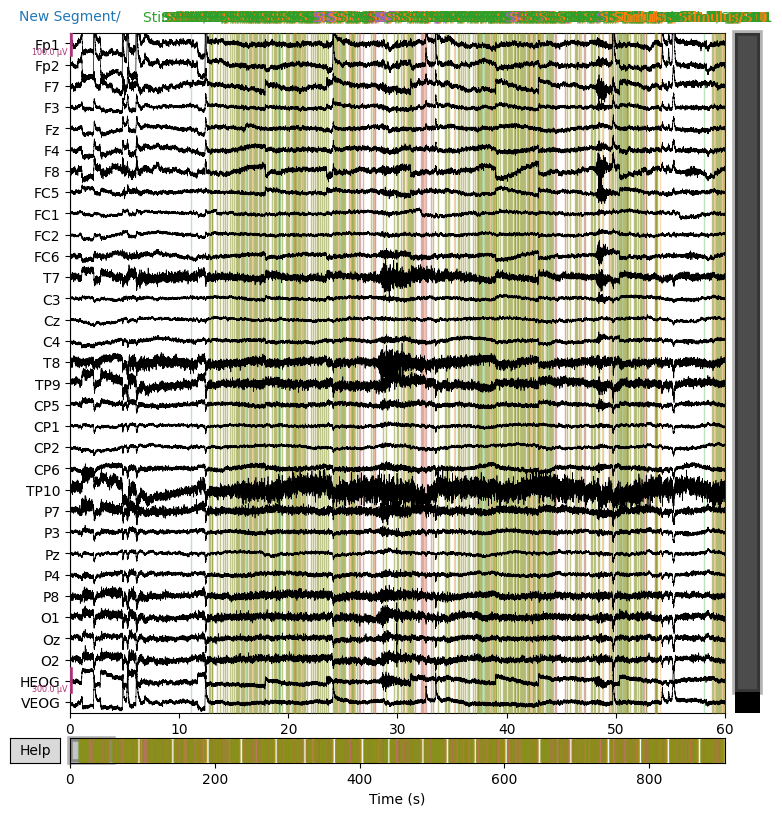

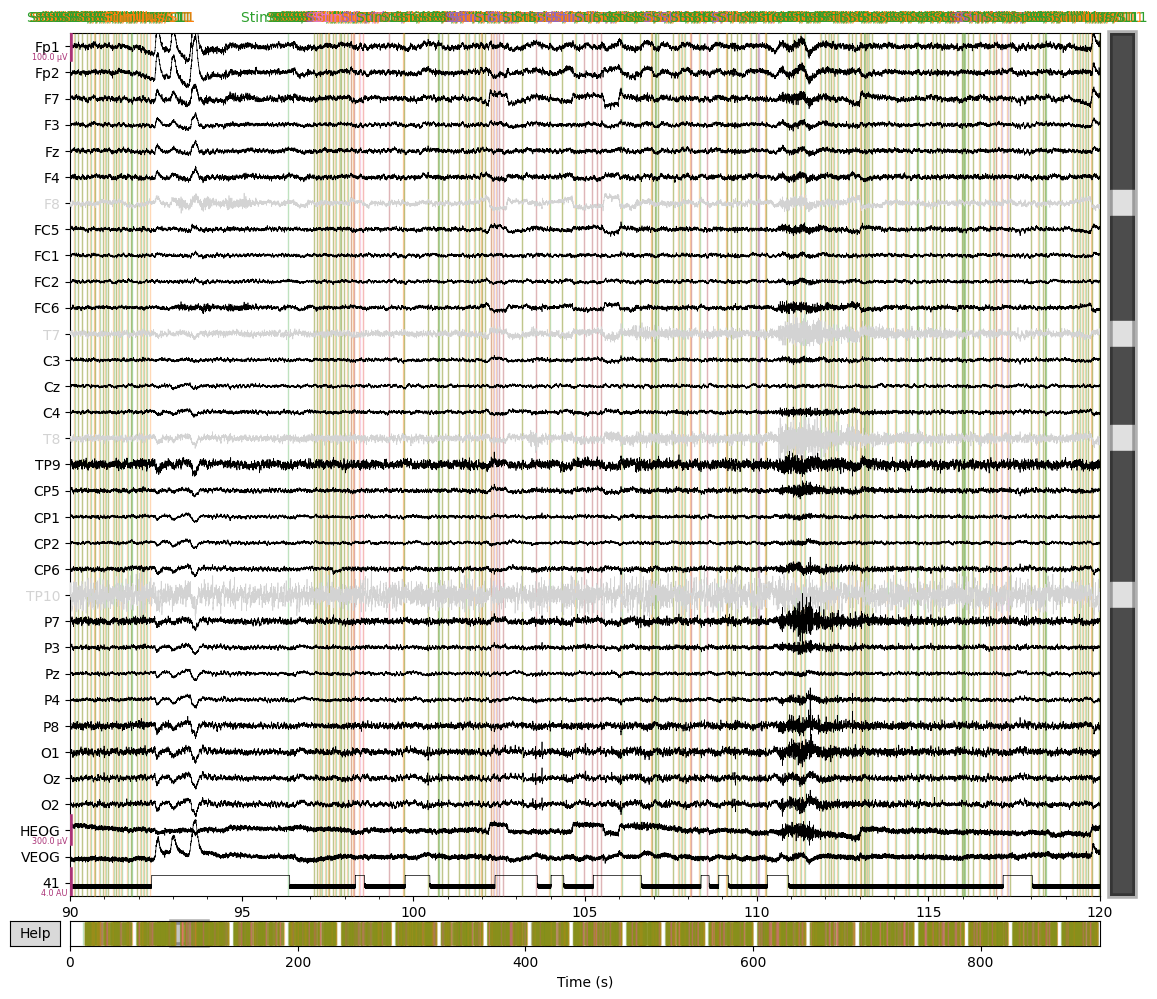

In [9]:
# Filtering data

raw = raw.filter(0.1,None)
raw_filtered = raw.copy().filter(1, None) #Used for ica preprocessing

#raw_filtered = raw.copy()

#raw_filtered.filter(
#    l_freq = 1, # pass everything over _ Hz
#    h_freq = 40, # pass everything below _ Hz
#)

bad_channels = {
    "group13_a": [
        "F8",
        "T7",
        "T8",
        "TP10",
    ],
    "group13_b": [
        "F8",
        "T7",
        "T8",
        "TP10",
    ],
    "group13_c": [
        "F8",
        "T7",
        "T8",
        "TP10",
    ],
}[SESSION]

raw_filtered.info["bads"] = bad_channels

raw_filtered.pick(
    picks=raw.ch_names, 
    exclude="bads"
)

# Plotting 
raw.plot(n_channels = 32, scalings = dict(eeg=50e-6), duration = 60);
#raw_ica.plot(n_channels = 32, scalings = dict(eeg=50e-6), duration = 60);

fig = raw_filtered.plot(
    start = preview_segmentation["begin"],
    duration = preview_segmentation["end"] - preview_segmentation["begin"],
    **PLOT_SETTINGS
)
fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_size_inches(12, 10)
plt.show()

In [ ]:
# eog_epochs = mne.preprocessing.create_eog_epochs(
#     raw, 
#     h_freq = 2,
#     baseline=(-0.3, -0.1)
# )
# eog_epochs.average().plot_joint(title = "Electrooculography");

Fitting ICA to data using 26 channels (please be patient, this may take a while)


Selecting by explained variance: 15 components
Fitting ICA took 12.7s.


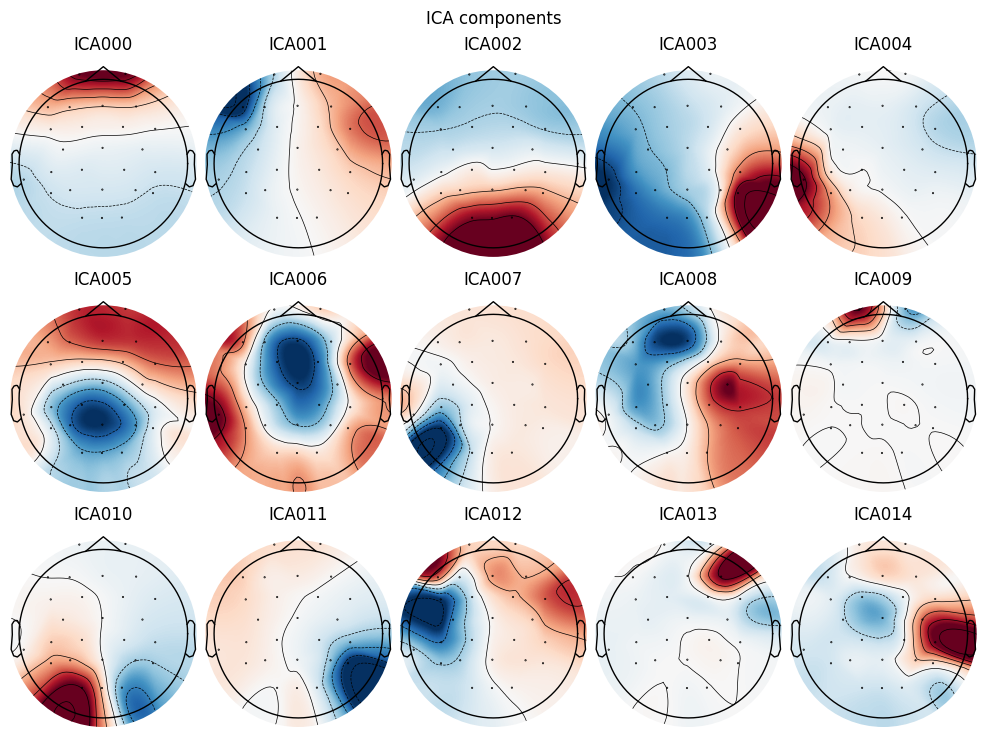

Creating RawArray with float64 data, n_channels=17, n_times=904900
    Range : 0 ... 904899 =      0.000 ...   904.899 secs
Ready.


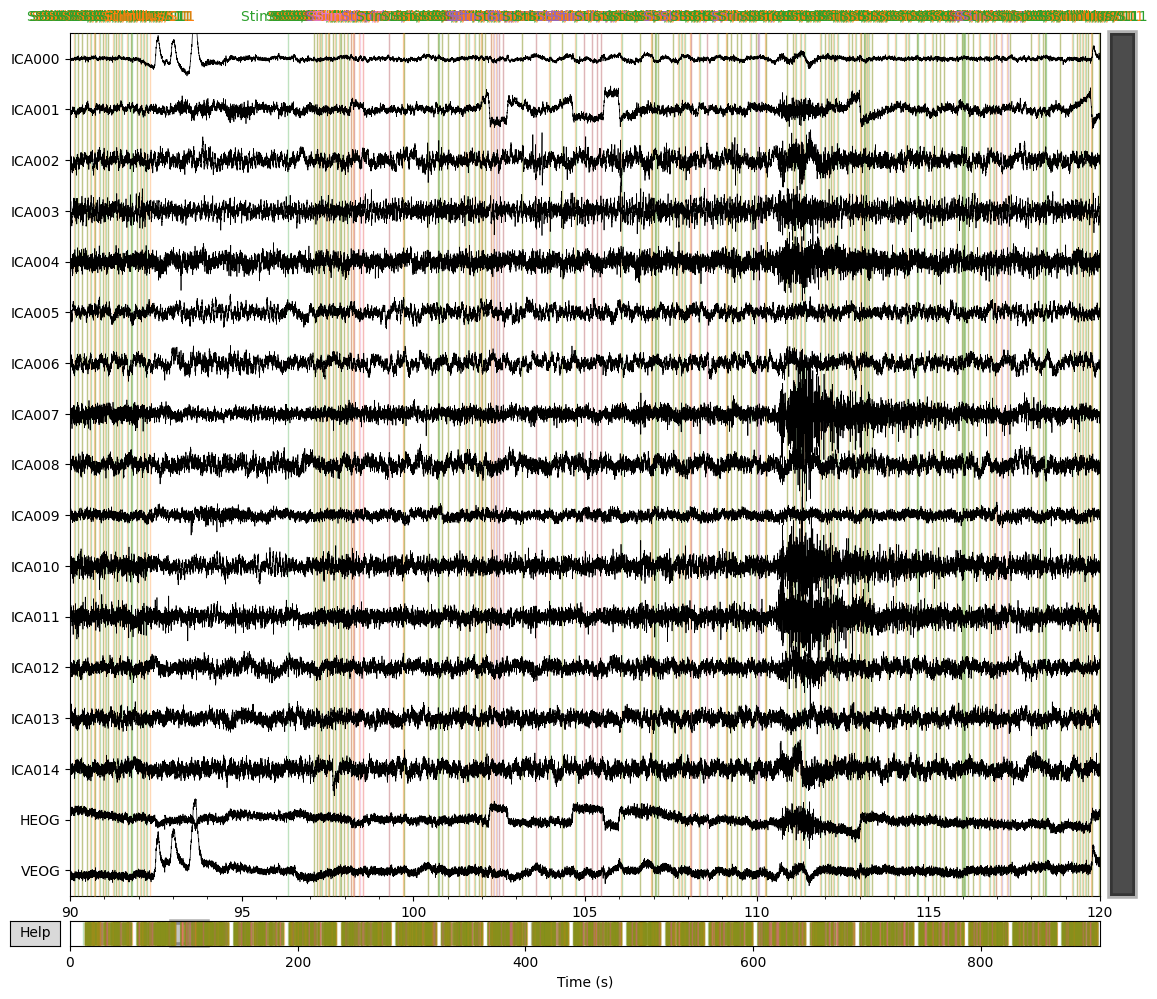

In [10]:
ica = mne.preprocessing.ICA(n_components=0.98, random_state=0, max_iter=800)
ica.fit(raw_filtered)
ica.plot_components();
fig = ica.plot_sources(
    raw_filtered,
    start = preview_segmentation["begin"],
    stop = preview_segmentation["end"],
    show = False,
)
fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_size_inches(12, 10)
plt.show()

Using EOG channels: HEOG, VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.

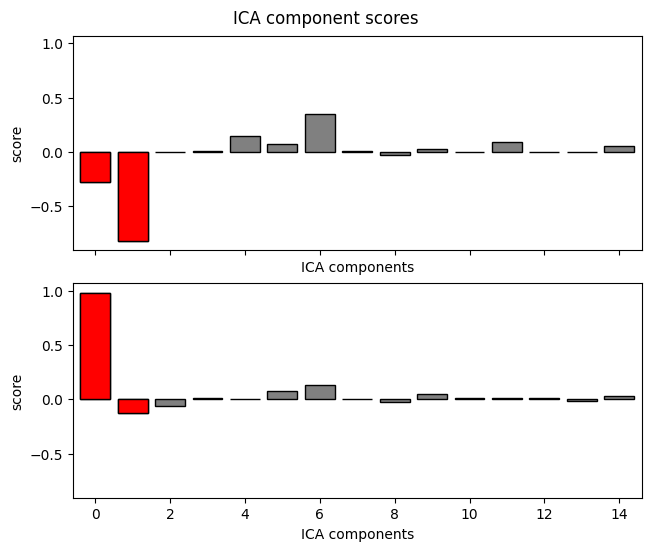

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
452 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
452 matching events found
No baseline correction applied
0 projection items activated


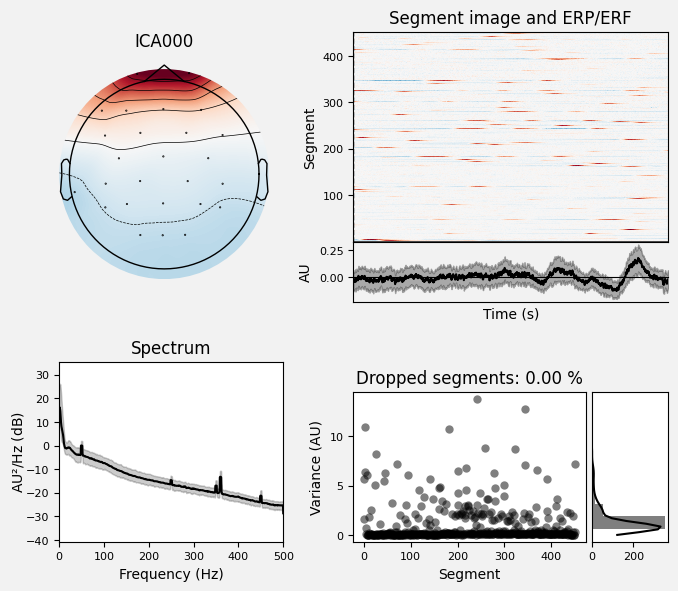

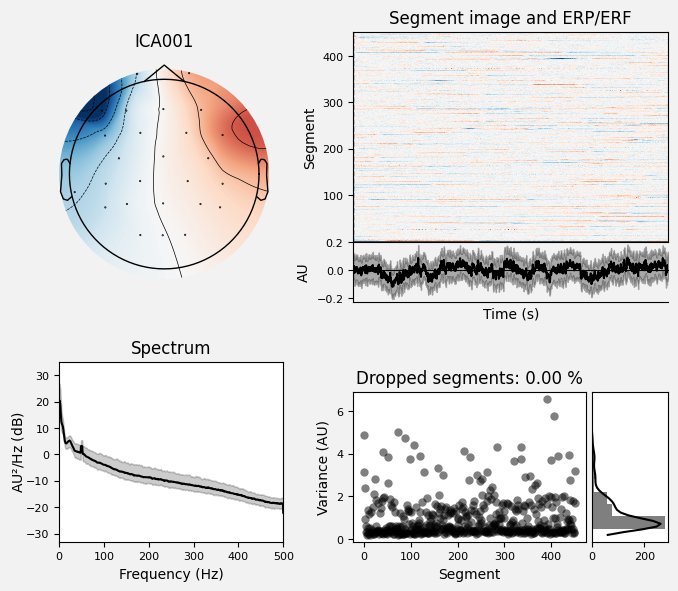

Creating RawArray with float64 data, n_channels=17, n_times=904900
    Range : 0 ... 904899 =      0.000 ...   904.899 secs
Ready.


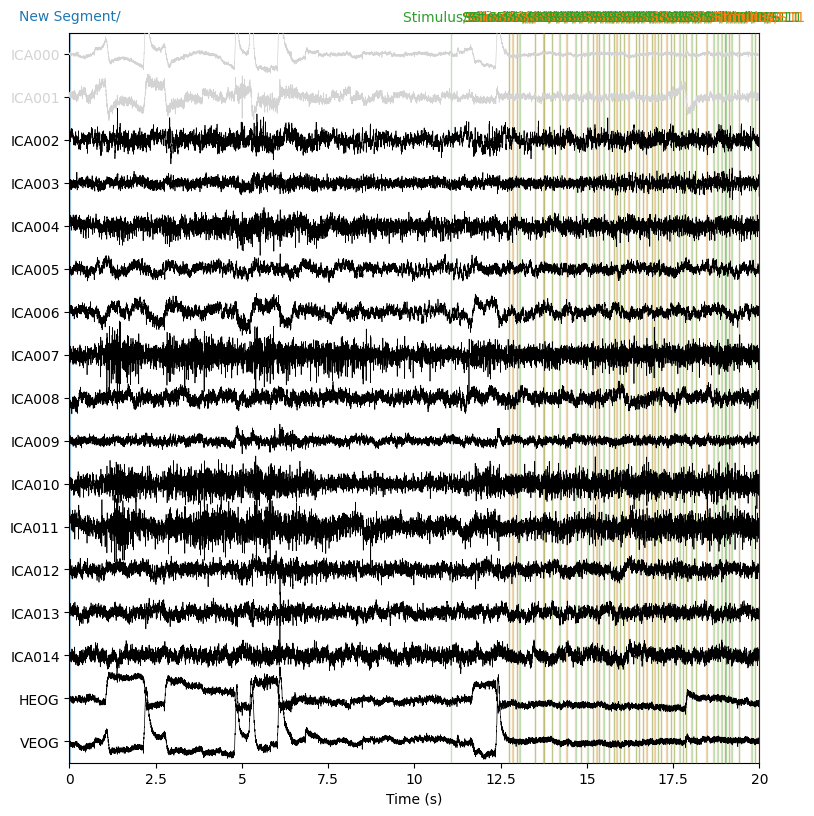

In [11]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw_filtered)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(raw_filtered, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw_filtered, show_scrollbars=False);

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
#ica.plot_sources(eog_evoked)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 26 PCA components


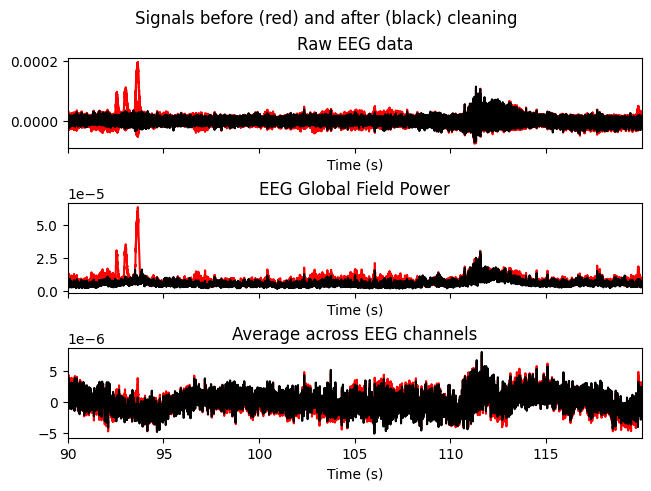

In [12]:
#artifact_ICAs = {
#    "group13_own": [0, 4],
#    "group13b_own": [0, 3],
#}[SESSION]

fig = ica.plot_overlay(
    raw, 
    #exclude=artifact_ICAs,
    start = preview_segmentation["begin"] * 1000,
    stop = preview_segmentation["end"] * 1000,
)

fig.axes[2].xaxis.set_major_locator(ticker.MultipleLocator(5))
fig.axes[2].xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

Applying ICA to Raw instance


    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 26 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


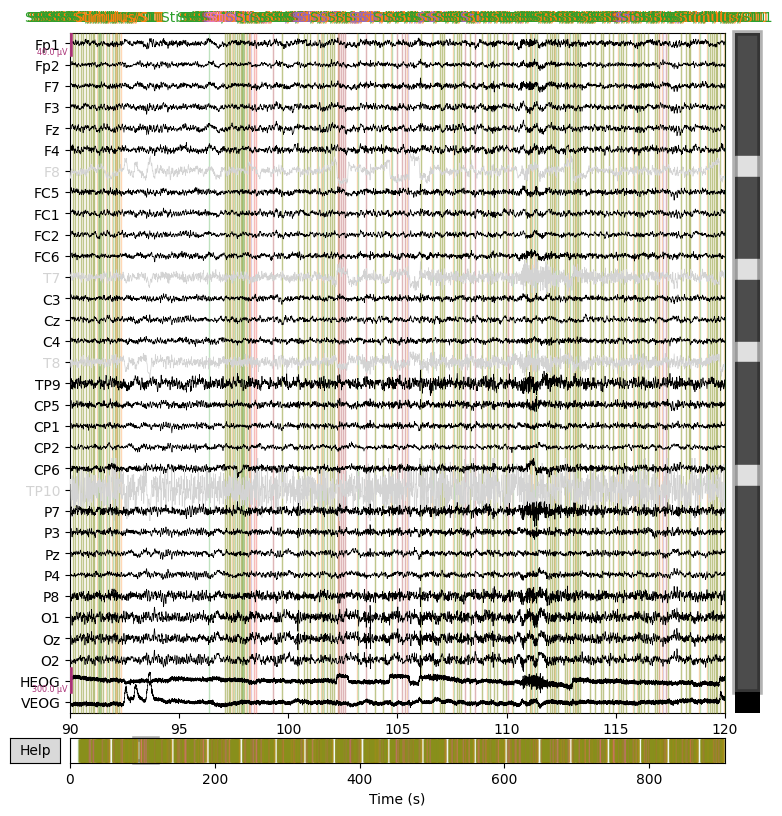

In [13]:
#ica.exclude = artifact_ICAs
raw_processed = ica.apply(raw)
raw_processed = raw_processed.filter(1,40)

raw_processed.info["bads"] = bad_channels

raw_processed.pick(
    picks=raw.ch_names, 
    exclude="bads"
)

#raw_processed.pick(["eeg"])
raw_processed.plot(n_channels=32, duration=30, start=90);

In [34]:
#raw_processed.set_eeg_reference(
#    "average", 
#    projection=False, 
#    verbose=False
#)

<RawBrainVision | group13b_own.eeg, 30 x 575880 (575.9 s), ~131.9 MB, data loaded>

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']


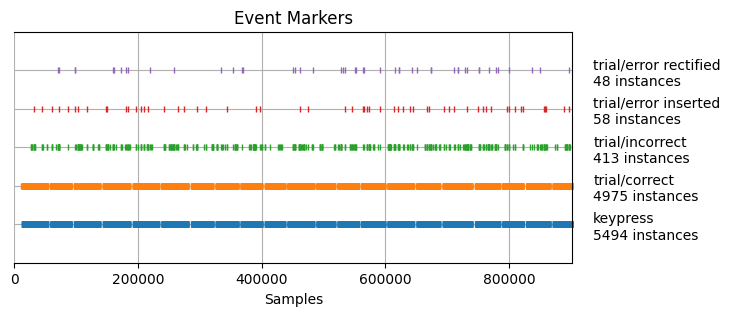

In [14]:
import sys
sys.path.append("..")
from constants import EEG_EVENT_ENCODINGS

events, event_ids = mne.events_from_annotations(raw)

fig = mne.viz.plot_events(
    events, 
    event_id = EEG_EVENT_ENCODINGS,
    color = dict(),
    on_missing = "ignore",
    show = False,
    verbose = "ERROR"
)
fig.set_size_inches(9, 3)
ax = fig.axes[0]
for line in ax.get_lines():
    line.set_marker("|")
    line.set_markersize(4)

ax.get_legend().remove()
ax.set_yticklabels([f"{key}\n{(events[:,2] == code).sum()} instances" for key, code in EEG_EVENT_ENCODINGS.items()])
plt.tick_params(
    axis="y", 
    which="both", 
    labelleft = False, 
    labelright = True,
    length = 0,
    pad = 15
)
ax.set_ylabel("")
ax.spines["left"].set_visible(False)
ax.set_title("Event Markers")
plt.show()

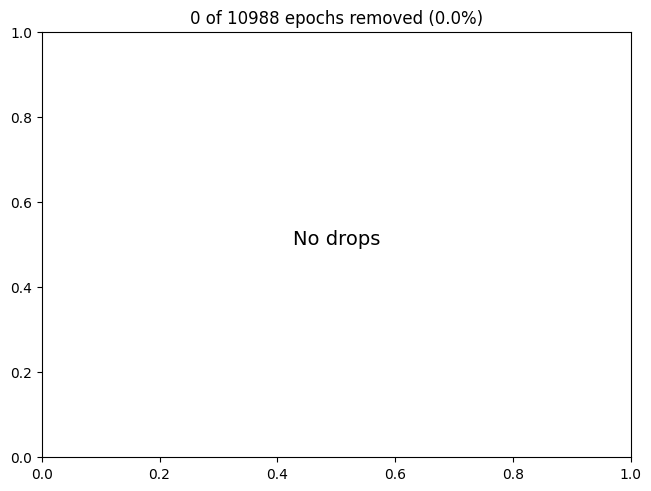

In [15]:
epochs = mne.Epochs(
    raw_processed, 
    events,
    event_id = EEG_EVENT_ENCODINGS, 
    picks = "eeg",
    reject = dict(eeg = 150e-6), 
    tmin = -0.2, 
    tmax = 0.6,
    baseline = (-0.2, 0),
    preload = True,
    verbose = False
)
#epochs.info
#epochs.drop_bad(reject=dict(eeg = 200e-6))
epochs.plot_drop_log();

In [16]:
print(f"{len([ep for ep in epochs.drop_log if len(ep)]) / len(events):.1%} of epochs were dropped")

0.0% of epochs were dropped


In [17]:
def get_response_times(conditions):
    event_codes = [EEG_EVENT_ENCODINGS["trial/" + event] for event in conditions]
    trials = np.where(np.isin(events[:,2], event_codes))[0]
    response_times = events[trials + 1][:-1,0] - events[trials][:-1,0]
    response_times = np.append(response_times, np.median(response_times))
    return sorted(np.divide(response_times, 1000))

def plot_sanity_check(name, conditions, sensors):
    epochs[conditions].plot_image(
        picks = sensors,
        title = f"""{name} ({", ".join(sensors)})\nConditional on Response Time""",
        overlay_times = get_response_times(conditions = conditions),
    )[0];

#plot_sanity_check(
#    name = "Positive Feedback",
#    conditions = ["correct", "error rectified"], 
#    sensors = ["O2"]
#    )

# plot_sanity_check(
#     name = "Negative Feedback",
#     conditions = ["incorrect", "error inserted"], 
#     sensors = ["O2"]
# )

# plot_sanity_check(
#     name = "Negative Feedback",
#     conditions = ["incorrect", "error inserted"], 
#     sensors = ["T7"]
# )

# plot_sanity_check(
#     name = "Inserted Errors",
#     conditions = ["error inserted"], 
#     sensors = ["Cz"]
# )

No projector specified for this dataset. Please consider the method self.add_proj.


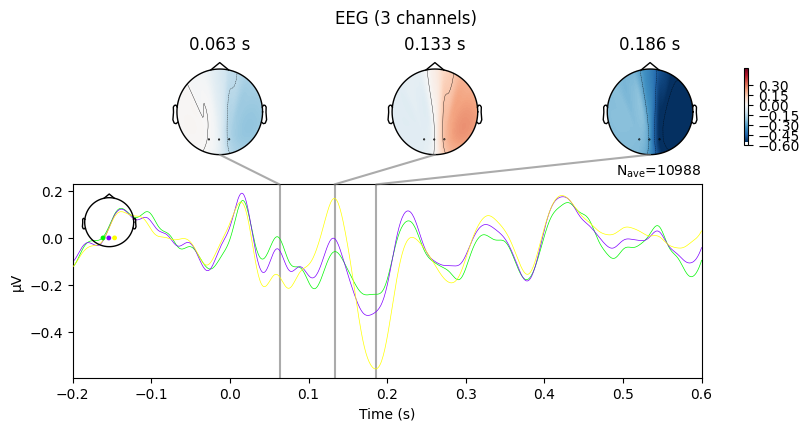

In [18]:
epochs.average(picks = ["O1","Oz","O2"]).plot_joint();

In [19]:
#epochs.resample(sfreq=250)

export_path = RAW_DATA_PATH.joinpath(SESSION + "2-epo.fif")

epochs.pick("eeg").save(export_path, overwrite = True)
print(f"[INFO] Exported epochs to {export_path}")

[INFO] Exported epochs to /work/PeterHoueWisnewski#4605/CogNeuro24/EEG/Exam/EEG/group13_a2-epo.fif
